<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/amr-elbana-inceptionV3/Orange_classification_Inception_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/Graduation Project/Dataset/original_dataset/train"
test_dir = "/content/drive/MyDrive/Graduation Project/Dataset/original_dataset/test"
batch_size = 32
target_size = (224, 224)
epochs = 50

# **Datset**

In [4]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
    validation_split=0.2,  # Use 20% of data for validation
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)


print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 1191 images belonging to 2 classes.
Found 297 images belonging to 2 classes.
Training samples: 1191
Validation samples: 297
Training batches per epoch: 38
Validation batches per epoch: 10


In [5]:
# Create an ImageDataGenerator for VGG16 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # VGG16-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 373 images belonging to 2 classes.
Test samples: 373
Test batches: 12


# **Model Architecture**

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 48,018,209 (183.17 MB)

 Trainable params: 26,215,425 (100.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [7]:
# Define callbacks
checkpoint_path = "/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_Inception_original{epoch:02d}-{val_acc:0.2f}.keras"
model_dir = "/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model"
# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(patience = 10)

# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping_monitor]
)
model.save('/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_Inception_original_best_model.keras')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.8026 - loss: 22.8264
Epoch 1: val_acc improved from -inf to 0.64310, saving model to /content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_Inception_original01-0.64.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 352s 8s/step - acc: 0.8047 - loss: 22.4820 - val_acc: 0.6431 - val_loss: 15.2041
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - acc: 0.9467 - loss: 0.7640
Epoch 2: val_acc did not improve from 0.64310
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 852ms/step - acc: 0.9469 - loss: 0.7598 - val_acc: 0.5522 - val_loss: 18.4536
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - acc: 0.9645 - loss: 0.7657
Epoch 3: val_acc did not improve from 0.64310
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 823ms/step - acc: 0.9642 - loss: 0.7681 - val_acc: 0.5825 - val_loss: 16.7139
Epoch 4/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - acc: 0.9667 - loss: 0.4858
Epoch 4: val_acc improved from 0.64310 to 0.67003, saving model to /content/drive/MyDrive/Gra

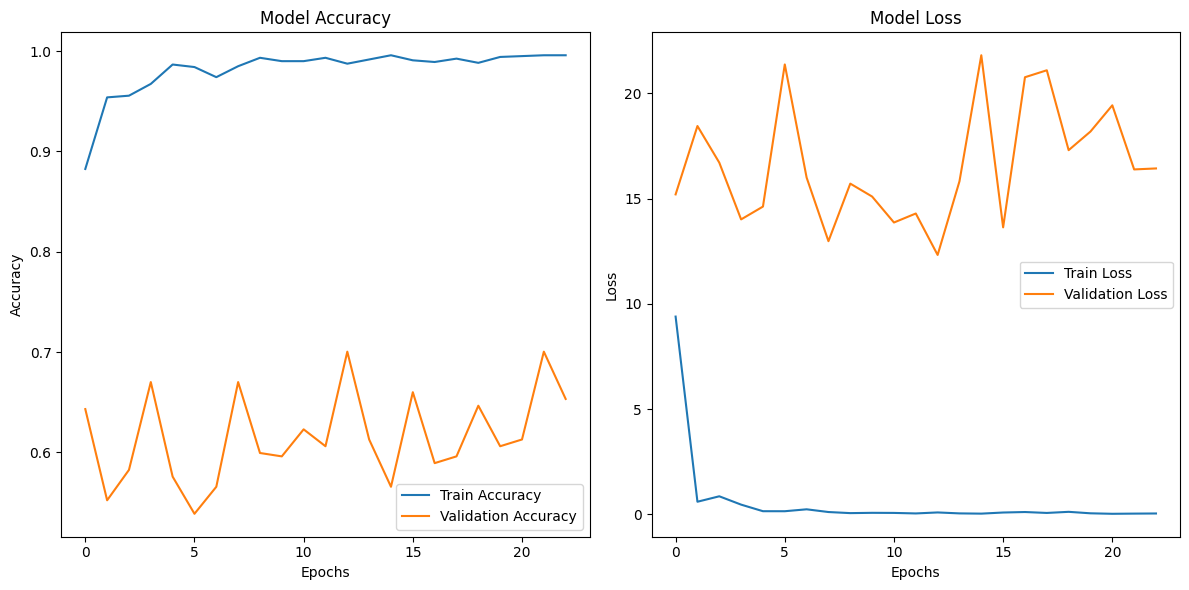

In [8]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
final_train_acc = History.history['acc'][-1]
final_val_acc = History.history['val_acc'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9958
Final Validation Accuracy: 0.6532
Final Training Loss: 0.0407
Final Validation Loss: 16.4375


In [10]:
print(f"Training stopped at epoch: {len(History.history['loss'])}")


Training stopped at epoch: 23


In [11]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'acc': [0.8824517130851746, 0.9538203477859497, 0.9554995894432068, 0.9672544002532959, 0.986565887928009, 0.984046995639801, 0.973971426486969, 0.984886646270752, 0.9932829737663269, 0.989924430847168, 0.989924430847168, 0.9932829737663269, 0.98740553855896, 0.991603672504425, 0.9958018660545349, 0.9907640814781189, 0.989084780216217, 0.992443323135376, 0.9882451891899109, 0.9941225647926331, 0.994962215423584, 0.9958018660545349, 0.9958018660545349], 'loss': [9.397686004638672, 0.5986282229423523, 0.8574993014335632, 0.46126946806907654, 0.14905200898647308, 0.1477382332086563, 0.23906156420707703, 0.10959941148757935, 0.057800497859716415, 0.07180412113666534, 0.06744806468486786, 0.0427447110414505, 0.09000914543867111, 0.04499294236302376, 0.03350353240966797, 0.08643614500761032, 0.10969723016023636, 0.06645514070987701, 0.11907052993774414, 0.049093086272478104, 0.025777701288461685, 0.03460713103413582, 0.04065920040011406], 'val_acc': [0.6430976390838623, 0.5521885752677917, 

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_Inception_original_best_model.keras'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 140s 12s/step
Confusion Matrix:
 [[172  13]
 [ 15 173]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.92      0.93      0.92       185
      Rotten       0.93      0.92      0.93       188

    accuracy                           0.92       373
   macro avg       0.92      0.92      0.92       373
weighted avg       0.92      0.92      0.92       373


Accuracy: 0.9249329758713136

F1 Score: 0.9251336898395722


In [13]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_inception_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_inception_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_inception_results.txt


In [14]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/Graduation Project/inceptionV3_Model/original model/orange_inception_confusion_matrix.png
